# 9. Hypothesis Testing

In this chapter we will look at hypothesis testing in R. We will start with single sample distributions and tests. Then, we will look at hypothesis tests when comparing two samples. Examples will include testing for positive correlations, performing a two sample paired t-test, and testing for equal variance among groups. The data we will use in this section comes from the Texas Health and Human Services Department and includes the reported number of induced terminations of pregnancy from 2016 to 2021 stratified by race and county. The data also contains population information about each county from the 2020 census including the number of women by county and race. Read the data documentation to see the full variable descriptions.

In [1]:
library(tidyverse)
library(fitdistrplus)
library(RforHDSdata)
library(gt)
library(gtsummary)
tex_itop <- read.csv("data/tex_itop.csv")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: survival


Attaching package: ‘gtsummary’


The following object is masked from ‘package:MASS’:

    select




## Univariate Distributions and One Sample Tests

Let's begin by looking at a single outcome of interest - the number of induced terminations of pregnancy (referred to as ITOPs or abortions below) per 1000 females in each county in 2021. We use the number of females as an estimate for the number of people who can give birth in each county. 

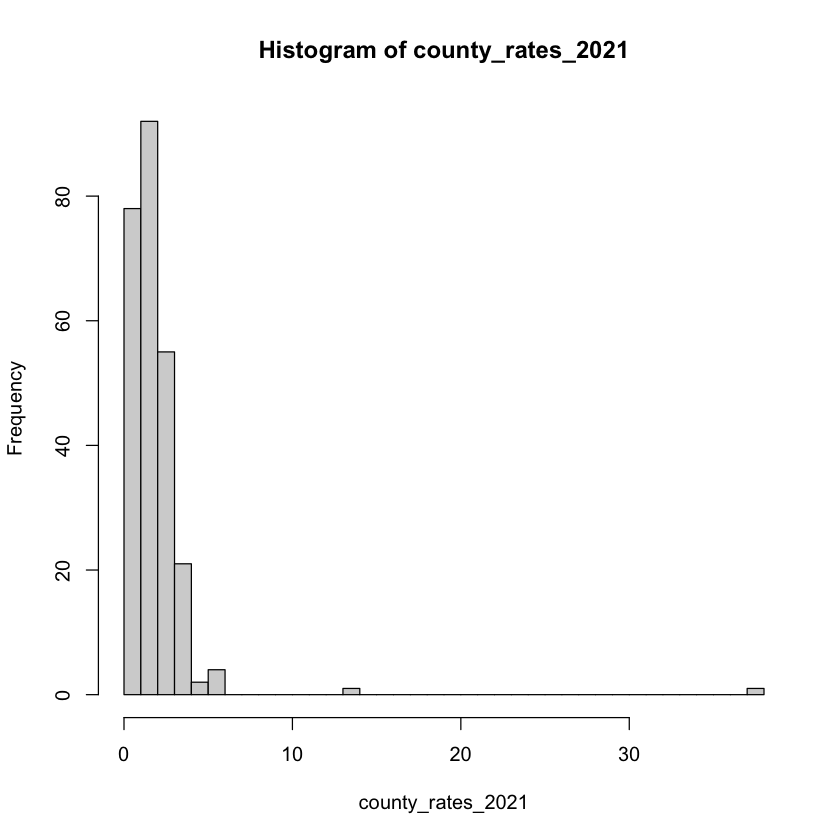

In [2]:
county_rates_2021 <- tex_itop$total_rate[tex_itop$year == 2021]
hist(county_rates_2021, breaks = 35)

We can see in the figure that this is a heavy-tailed distribution. Below we find the 10 counties with highest rates and see that there are some counties with under 1000 people that have some of the highest rates of abortions whereas Travis county, which contains the city of Austin, is also included in the top 10. 

In [3]:
tex_itop %>% 
  filter(year==2020) %>% 
  slice_max(n=10, total_rate) %>%
  dplyr::select(c(county, total_itop, tot_pop, total_rate))

county,total_itop,tot_pop,total_rate
<chr>,<int>,<int>,<dbl>
Loving,2,27,74.074074
Terrell,3,371,8.086253
King,1,142,7.042254
McMullen,2,299,6.688963
Harris,14086,2400848,5.867094
Dallas,7325,1322590,5.538375
Kenedy,1,181,5.524862
Bell,1005,189865,5.293235
Travis,3328,640228,5.198148


Given that we are observing a rate, we may want to approximate this distribution using a Poisson distribution. To do so, we can find the mean rate as an estimate for the paramter $\lambda$.

In [4]:
mean(county_rates_2021, na.rm=TRUE)

[1] 1.793928

Alternatively, we can use the `fitdist()`, which takes in a numeric vector `data` and a character name of the distribution `distr` and returns the estimated parameters for the distribution. By default this function uses maximum likelihood estimation, but you can also specify other methods by setting the `method` argument.

In [5]:
#fitdist(county_rates_2021, "nbinom", method = "mle")

Within R we can also calculate a confidence for the rate lambda. Recall that a $(1-\alpha)$%  confidence interval for $\lambda$ is given by the equation below where $\hat{\lambda}$ is our estimated rate and $n$ is the number of observations.
$$\hat{\lambda} \pm z_{1-\alpha/2} \cdot \sqrt{\hat{\lambda}/n}$$

In [6]:
est_mean <- mean(county_rates_2021, na.rm=TRUE)
z_alpha <- dnorm(1-0.05/2)
n <- length(county_rates_2021)
c(est_mean - z_alpha*sqrt(est_mean/n), est_mean + z_alpha*sqrt(est_mean/n))

[1] 1.773085 1.814772

If we want to display this nicely, we can use the `round()` function, which allows us to specify a number of digits, and the `paste()` function which creates a single character string from multiple inputs. 

In [7]:
lower <- round(est_mean - z_alpha*sqrt(est_mean/n),3)
upper <- round(est_mean + z_alpha*sqrt(est_mean/n),3)
paste("Confidence Interval: (", lower, ",", upper, ")")

[1] "Confidence Interval: ( 1.773 , 1.815 )"

In [8]:
1000*22354/(sum(tex_itop$tot_pop, na.rm=TRUE)/2)

[1] 1.515441

Suppose that we wanted to run a hypothesis test to compare the mean to a pre-determined value. In particular, the Texas Heartbeat Act was introduced in 2021 and drastically reduced the number of eligible abortions. We could test whether there were significantly fewer abortions in 2021 compared to 2020. Our null hypothesis is that $\lambda \geq 0.766$. To run this hypothesis test, we use the `t.test()` function. For a one sample t-test, we need to specify our sample `x`, the alternative hypothesis `alternative` (default is a two-sided test), the true value of the mean `mu` (default 0), and a confidence level `conf.level` (default 0.95). Below, we fail to reject the null hypothesis. 

In [9]:
t.test(county_rates_2021, alternative = "less", mu = 0.766, conf.level=0.95)


	One Sample t-test

data:  county_rates_2021
t = 6.2926, df = 253, p-value = 1
alternative hypothesis: true mean is less than 0.766
95 percent confidence interval:
     -Inf 2.063611
sample estimates:
mean of x 
 1.793928 


The one-sample Wilcoxon signed rank test is a non-parametric alternative to one-sample t-test, which can be used to compare the median value of a sample to a theoretical value and does not assume the data is normally distributed. This test is performed by the `wilcox.test()` function and takes in the same arguments as the `t.test()` function.

In [10]:
wilcox.test(county_rates_2021, alternative = "less", mu = 0.766, conf.level=0.95)


	Wilcoxon signed rank test with continuity correction

data:  county_rates_2021
V = 27753, p-value = 1
alternative hypothesis: true location is less than 0.766


## Two Sample Tests

We now look at two sample tests. To start we look at the 2020 and 2021 rates by county. We pivot our data into a wider format in order to create 2020 and 2021 rate columns. We then create a scatter plot of 2021 vs 2020 rates. We observe a linear correlation between the two.

In [11]:
county_rates <- tex_itop %>%
  dplyr::select(c(county, total_rate, year)) %>%
  pivot_wider(names_from = year, values_from = total_rate) %>%
  na.omit() %>%
  rename("y2020"="2020", "y2021"="2021")
head(county_rates)

county,y2020,y2021
<chr>,<dbl>,<dbl>
Anderson,2.3537617,1.7435272
Andrews,0.7568386,0.3243594
Angelina,2.1270337,2.1949177
Aransas,0.9208103,1.9253307
Archer,0.4652245,0.2326122
Armstrong,0.0000000,0.0000000


Warning message:
“Removed 16 rows containing missing values (`geom_point()`).”


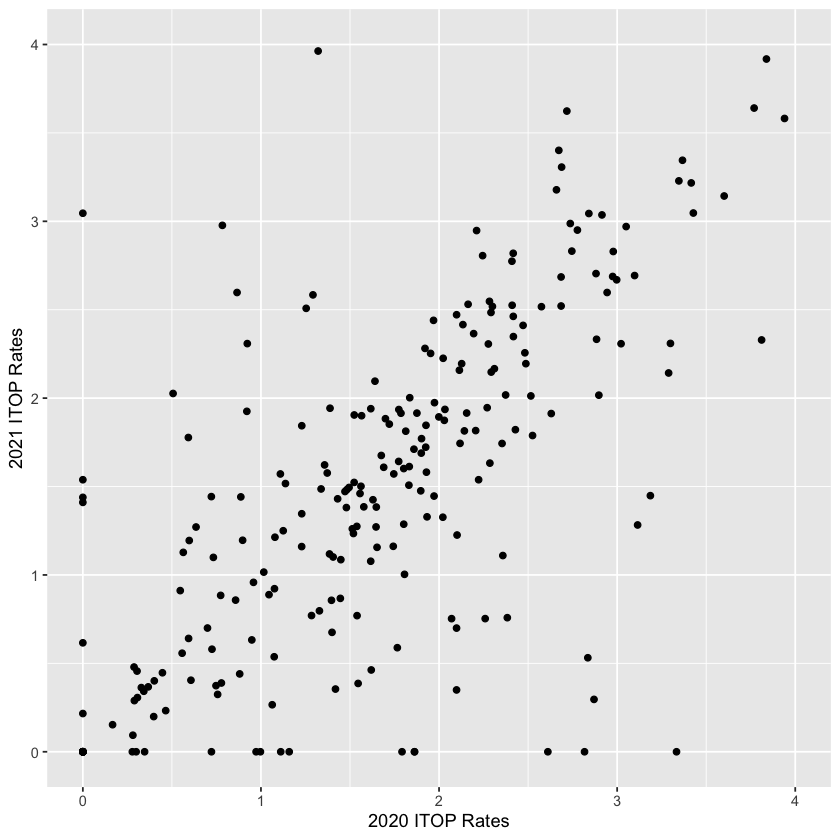

In [12]:
ggplot(county_rates) + 
 geom_point(aes(x=y2020,y=y2021)) +
 scale_x_continuous(limits=c(0,4)) + 
 scale_y_continuous(limits=c(0,4)) +
 labs(x="2020 ITOP Rates", y="2021 ITOP Rates")

We have seen before how to calculate the correlation between two columns using the `cor()` function. We can also calculate the covariance using the `cov()` function. As suspected, there is a strong correlation and covariance.

In [13]:
cor(county_rates$y2020, county_rates$y2021)
cov(county_rates$y2020, county_rates$y2021)

[1] 0.9160842

[1] 11.23596

Besides the correlation, we can also test whether there is a non-zero correlation. The function `cor.test()` tests for association between paired samples, using one of Pearson's product moment correlation coefficient, Kendall's $\tau$, or Spearman's $\rho$. Similar to the `t.test()` and `wilcox.test()` functions we can also specify the `alternative` and `conf.level` arguments. Below we test whether there is a non-zero correlation using Pearson's product-moment correlation.

In [14]:
cor.test(county_rates$y2020, county_rates$y2021, method="pearson")


	Pearson's product-moment correlation

data:  county_rates$y2020 and county_rates$y2021
t = 36.267, df = 252, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.8937783 0.9338695
sample estimates:
      cor 
0.9160842 


## Two Sample Tests for Means

## Two Sample Tests

create table one with p-values

how are p-values calculated



### Two Sample Tests for Means

fisher test (all sample size) and chi squared test (large sample size)

two sample t-test, one way anova

wilcox rank test 

### Two Sample Tests for Variance

levene test (> 2 grps) or F-test (2 grps)

## Adding Hypothesis Tests to Summary Tables

Earlier we used the `gt` and `gtsummary` packages to add a summary table. We can 

In [15]:
tbl_summary(tex_itop, include = c(total_rate, white_rate, asian_rate, hispanic_rate, 
                                  black_rate, native_american_rate),
           by = "year", statistic = list(all_continuous() ~ "{mean} ({sd})")) %>% 
  as_gt() %>% 
  gt:::as.tags.gt_tbl()

Shiny tags cannot be represented in plain text (need html)